In [61]:
import pandas as pd
import numpy as py
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

data_files = [
        "ap_2010.csv",
        "class_size.csv",
        "demographics.csv",
        "graduation.csv",
        "hs_directory.csv",
        "sat_results.csv"
]

data = {}

# type: 0: lat, 1: long
# string has: lat, long
def extractGeo(v, type):
    regexResult = re.findall("\(([^\)]+)\)", v)
    if(len(regexResult) > 0):
        strLatLon = regexResult[0]
        arrLatLon = strLatLon.split(",")
        return arrLatLon[type].strip()
    
for file in data_files:
    fileName = file.split(".")
    temp_data = pd.read_csv("schools/" + file)
    data[fileName[0]] = temp_data

#work around to add the column sat_score
data['sat_results']['SAT Critical Reading Avg. Score'] = data['sat_results']['SAT Critical Reading Avg. Score'].apply(pd.to_numeric, errors='coerse')
data['sat_results']['SAT Math Avg. Score'] = data['sat_results']['SAT Math Avg. Score'].apply(pd.to_numeric, errors='coerse')
data['sat_results']['SAT Writing Avg. Score'] = data['sat_results']['SAT Writing Avg. Score'].apply(pd.to_numeric, errors='coerse')

# re.findall("\(([^\)]+)\)", "1110 Boston Road\nBronx, NY 10456\n(40.8276026690005, -73.90447525699966)")
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(extractGeo, args=(0,))
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(extractGeo, args=(1,))

data["hs_directory"]["lon"] = data["hs_directory"]["lon"].apply(pd.to_numeric, errors="coerce")
data["hs_directory"]["lat"] = data["hs_directory"]["lat"].apply(pd.to_numeric, errors="coerce")


data['sat_results']['sat_score'] = ((data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']))
data['sat_results']['sat_score'] = data['sat_results']['sat_score'].apply(pd.to_numeric, errors='coerse')
    
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding="windows-1252")

data["survey"] = all_survey

class_size = data["class_size"].loc[(data["class_size"]["GRADE "] == "09-12") & (data["class_size"]["PROGRAM TYPE"] == 'GEN ED')]

def paddingZeros(v):
    v = v.zfill(2);
    return v

data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(str)
data["class_size"]["padded_csd"] = data["class_size"]["padded_csd"].apply(paddingZeros)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

class_size = data["class_size"].loc[(data["class_size"]["GRADE "] == "09-12") & (data["class_size"]["PROGRAM TYPE"] == 'GEN ED')]

class_size = class_size.groupby("DBN").aggregate(py.mean)
class_size.reset_index(inplace=True)

data["class_size"] = class_size


data["graduation"] = data["graduation"].loc[(data["graduation"]["Cohort"] == '2006')]

data["graduation"] = data["graduation"].loc[(data["graduation"]["Demographic"] == 'Total Cohort')]

data["ap_2010"][['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']] = data["ap_2010"][['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']].apply(pd.to_numeric, errors='coerse')

combined = data["sat_results"].merge(data["ap_2010"], how="left", on="DBN")
combined = combined.merge(data["graduation"], how="left", on="DBN")
combined = combined.merge(data["class_size"], how="inner", on="DBN")
combined = combined.merge(data["demographics"], how="inner", on="DBN")
combined = combined.merge(data["survey"], how="inner", left_on="DBN", right_on="dbn")
combined = combined.merge(data["hs_directory"], how="inner", right_on="dbn", left_on="dbn")

def extractTwoLetters(str):
    return str[0:2]

combined["school_dist"] = combined["DBN"].apply(extractTwoLetters)

combined.head(5)



,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.98526,01
1,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.98526,01
2,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.98526,01
3,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.98526,01
4,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.98526,01


In [62]:
combined.columns

Index([                            u'DBN',                     u'SCHOOL NAME',
                u'Num of SAT Test Takers', u'SAT Critical Reading Avg. Score',
                   u'SAT Math Avg. Score',          u'SAT Writing Avg. Score',
                             u'sat_score',                      u'SchoolName',
                       u'AP Test Takers ',               u'Total Exams Taken',
       ...
                            u'Location 1',                 u'Community Board',
                      u'Council District',                    u'Census Tract',
                                   u'BIN',                             u'BBL',
                                   u'NTA',                             u'lat',
                                   u'lon',                     u'school_dist'],
      dtype='object', length=2085)

In [63]:
correlations = combined.corr()

In [64]:
for d in data:
    print(d)
    print(data[d].columns)
   


sat_results
Index([u'DBN', u'SCHOOL NAME', u'Num of SAT Test Takers',
       u'SAT Critical Reading Avg. Score', u'SAT Math Avg. Score',
       u'SAT Writing Avg. Score', u'sat_score'],
      dtype='object')
demographics
Index([u'DBN', u'Name', u'schoolyear', u'fl_percent', u'frl_percent',
       u'total_enrollment', u'prek', u'k', u'grade1', u'grade2', u'grade3',
       u'grade4', u'grade5', u'grade6', u'grade7', u'grade8', u'grade9',
       u'grade10', u'grade11', u'grade12', u'ell_num', u'ell_percent',
       u'sped_num', u'sped_percent', u'ctt_num', u'selfcontained_num',
       u'asian_num', u'asian_per', u'black_num', u'black_per', u'hispanic_num',
       u'hispanic_per', u'white_num', u'white_per', u'male_num', u'male_per',
       u'female_num', u'female_per'],
      dtype='object')
graduation
Index([u'Demographic', u'DBN', u'School Name', u'Cohort', u'Total Cohort',
       u'Total Grads - n', u'Total Grads - % of cohort', u'Total Regents - n',
       u'Total Regents - % of cohor

In [65]:
# not sure why, bbut this column is missing here.

correlations.filter(items=["sat_score"])

,sat_score
SAT Critical Reading Avg. Score,0.986650
SAT Math Avg. Score,0.972547
SAT Writing Avg. Score,0.988028
sat_score,1.000000
AP Test Takers,0.620067
Total Exams Taken,0.609731
Number of Exams with scores 3 4 or 5,0.615713
Total Cohort,0.329433
CSD,0.050000
NUMBER OF STUDENTS / SEATS FILLED,0.400370


In [66]:
#next line to plot the charts in jupyter
%matplotlib inline

import matplotlib as plt

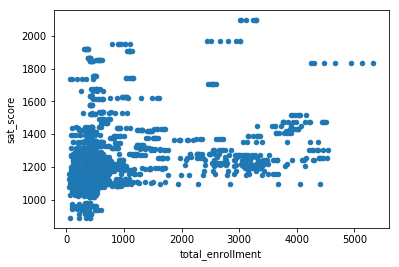

In [67]:
combined.plot.scatter(x="total_enrollment", y="sat_score")

In [68]:
# 6

# Filter the combined dataframe to keep only those rows where total_enrollment is under 1000 and sat_score is under 1000. Assign the result to low_enrollment.
# Display all of the items in the School Name column of low_enrollment.
# Use Wikipedia and Google to research the names of the schools. Can you discover anything interesting about them?

low_enrollment = combined[(combined["total_enrollment"] < 1000) & (combined["sat_score"] < 1000)]

In [69]:
low_enrollment

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
579,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
580,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
581,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
582,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
583,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
584,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,NaN,NaN,NaN,...,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",1.0,8.0,41.0,2000391.0,2.022860e+09,Mott Haven-Port Morris ...,40.810036,-73.917812,07
806,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.0,20.0,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.0,14.0,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
807,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.0,20.0,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.0,14.0,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
808,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.0,20.0,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.0,14.0,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09
809,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.0,20.0,...,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",5.0,14.0,21502.0,2008460.0,2.028660e+09,University Heights-Morris Heights ...,40.849102,-73.916088,09


In [70]:
low_enrollment["SCHOOL NAME"].unique()

array(['INTERNATIONAL COMMUNITY HIGH SCHOOL',
       'ACADEMY FOR LANGUAGE AND TECHNOLOGY',
       'BRONX INTERNATIONAL HIGH SCHOOL',
       'KINGSBRIDGE INTERNATIONAL HIGH SCHOOL',
       'INTERNATIONAL SCHOOL FOR LIBERAL ARTS',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE',
       'HIGH SCHOOL OF WORLD CULTURES',
       'BROOKLYN INTERNATIONAL HIGH SCHOOL',
       'INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS',
       'IT TAKES A VILLAGE ACADEMY', 'MULTICULTURAL HIGH SCHOOL',
       'PAN AMERICAN INTERNATIONAL HIGH SCHOOL'], dtype=object)

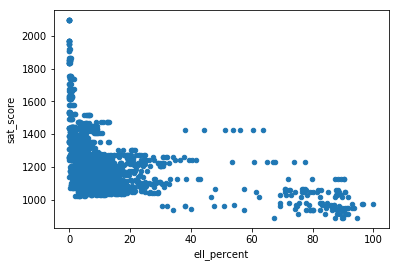

In [71]:
# 7

# Create a scatterplot of ell_percent versus sat_score.

combined.plot.scatter(x="ell_percent", y="sat_score")

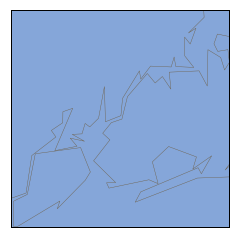

In [72]:
# 8

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

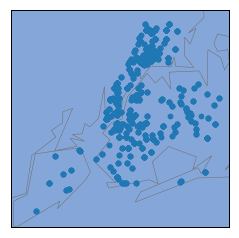

In [91]:
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].values
latitudes = combined["lat"].values

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True)

plt.show()

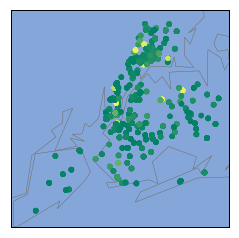

In [92]:
# 10

from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].values
latitudes = combined["lat"].values

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")

plt.show()

In [97]:
# 11

# Find the average values for each column for each school_dist in combined.
# Use the pandas.DataFrame.groupby() method to group combined by school_dist.
# Use the agg() method, along with the numpy.mean function as an argument, to calculate the average of each group.
# Assign the result to the variable districts.
# Reset the index of districts, making school_dist a column again.
# Use the pandas.DataFrame.reset_index() method with the keyword argument inplace=True.
# Display the first few rows of districts to verify that everything went okay.

import numpy

districts = combined.groupby("school_dist").aggregate(numpy.mean)

districts.reset_index(inplace=True)

districts.head(5)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,postcode,total_students,number_programs,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,104.333333,149.000000,100.500000,93.500000,1.0,...,10003.166667,659.500000,1.333333,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,429.788194,447.913194,428.260417,1305.961806,128.814815,205.000000,161.541667,153.264085,2.0,...,10025.270627,645.099010,1.442244,4.087838,2.560811,1188.557432,1.040743e+06,1.007553e+09,40.739504,-73.991267
2,03,436.666667,444.111111,436.000000,1316.777778,194.200000,311.000000,312.000000,179.888889,3.0,...,10023.704225,773.802817,2.183099,7.591549,6.591549,166.239437,1.035445e+06,1.012958e+09,40.780811,-73.977911
3,04,402.142857,416.285714,405.714286,1224.142857,129.000000,166.333333,145.000000,113.857143,4.0,...,10029.857143,580.857143,1.142857,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215
4,05,438.789474,449.947368,430.368421,1319.105263,71.515152,87.212121,115.000000,127.333333,5.0,...,10030.581395,633.232558,1.162791,9.488372,8.302326,9687.860465,1.063557e+06,1.019714e+09,40.817535,-73.948341


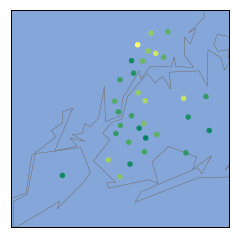

In [98]:
# 12

# Use the code snippet from before that creates a map, then draws rivers, coastlines, and boundaries.
# Convert the lon column of districts to a list, and assign it to the longitudes variable.
# Convert the lat column of districts to a list, and assign it to the latitudes variable.
# Call the scatter() method on m, and pass in longitudes and latitudes as arguments.
# Make sure to pass in longitudes and latitudes in the correct order.
# Pass in the keyword argument s=50 to increase the size of the points in the scatterplot.
# Pass in the keyword argument zorder=2 to plot the points on top of the rest of the map. Otherwise the method will draw the points underneath the land.
# Pass in the keyword argument latlon=True to indicate that we're passing in latitude and longitude coordinates, rather than axis coordinates.
# Pass in the keyword argument c with the value districts["ell_percent"] to plot the ell_percent.
# Pass in the keyword argument cmap="summer" to get the right color scheme.
# Show the plot using the show() method.

from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].values
latitudes = districts["lat"].values

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")

plt.show()




In [99]:
# Done.